# Panoramsko spajanje slika

Osnovni problem: *Kako iskombinovati mnostvo slika i kreirati jednu vecu sliku - panoramu.*

Ovaj problem sastoji se od nekoliko koraka:
1. Izdvanjanje skupa zajednickih tacaka. odnosno prepoznavanje geometrijske veze izmedju slika
<br><img src="images/feature_extraction.png" alt="Feature extraction" width="700"/>

2. Izracunavanje homografije. Homografija je transformacija kojom se jedna slika prebacuje u svet druge slike. Prakticno poravnanje slika.
Nakon ovog koraka dobiju se slike koje su "nadovezane" jedna na drugu.
<br><img src="images/stiched_image.png" alt="Feature extraction" width="700"/>

3. Stapanje slika, jer slike skoro nikada nece biti slikane sa istom ekspozicijom
<br><br><img src="images/blending.png" alt="Feature extraction" width="500"/>

4. Opcioni korak u kom se po potrebi od dobijenog rezultata izvlaci najbolja moguca pravougaona slika sa sto manje gubitaka podataka

In [2]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
examples_folder = './example'

input_images = []
for filename in sorted(os.listdir(examples_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(examples_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            input_images.append(img)
        else:
            print(f"Could not read {filename}")

print(f"Total input_images loaded: {len(input_images)}")

Total input_images loaded: 76


## Izdvajanje skupa zajednickih tacaka

Prvi problem koji treba resiti je izracunavanje kljucnih tacaka na slikama.

**Ključne tačke** su posebne tačke koje imaju karakteristicne i prepoznatljive osobine koje imaju jedinstvenu poziciju na slici.

One su interesantne zato što se lako mogu naći i pratiti u različitim slikama, čak i ako su slike rotirane, skalirane ili slikane pod razlicitim osvetljenjem.
Primer kljucnih tacaka: vrh trougla ili slova na slici.

Uz njih, potrebno je izracunati i deskriptore.
</br></br>

**Deskriptori** su brojevi koji numericki opisuju izgled okoline neke kljucne tacke na slici i veoma su vazni za uparivanje kljucnih tacaka izmedju slika. Dakle, dok ključna tačka predstavlja poziciju na slici, deskriptor je detaljan opis tog mesta. Zahvaljujuci njima algoritmi su robusni i otporni na sve promene objekta na razlicitim slikama.
</br></br>


Popularni algoritmi za detekciju ključnih tačaka i formiranje deskriptora:
1. **Harris Corner Detector** - Detektuje uglove na slici. Nije robustan za promene skaliranja ili rotacije, ali je brz i jednostavan.

2. **SIFT (Scale-Invariant Feature Transform)** - Pronalazi ključne tačke i opisuje ih tako da su invarijantne na promene veličine, rotacije i osvetljenja. Vrlo popularan i pouzdan.

3. **SURF (Speeded-Up Robust Features)** - Brža verzija SIFT-a, takođe invarijantna na skaliranje i rotaciju.

4. **ORB (Oriented FAST and Rotated BRIEF)** - Brz i efikasan algoritam, često se koristi kao besplatna alternativa za SIFT i SURF.
</br></br>

Kada su izracunate kljucne tacke i deskriptori za obe slike potrebno ih je upariti na odgovarajuci nacin.

Poznati algoritmi i pristupi za uparivanje:
1. **Brute-Force Matcher (BFMatcher)** - Upoređuje svaki deskriptor sa svim deskriptorima na drugoj slici. Koristi metrike poput Euklidskog rastojanja (za SIFT, SURF) ili Hamingovog rastojanja (za ORB). Spor, ali vrlo jednostavan.

2. **FLANN (Fast Library for Approximate Nearest Neighbors)** - Efikasniji algoritam za pronalaženje najbližih suseda u velikim skupovima podataka. Koristi se za brže i skalabilnije uparivanje. Popularan za SIFT i SURF.
</br></br>

Kao dodatak na oba algoritma potrebno je na neki nacin isfiltrirati lazna podudaranja izmedju deskriptora kljucnih tacaka dve slike, jer za svaku tacku prve slike bice nekoliko potencijalnih poklapanja na drugoj slici od kojih ce dosta njih biti "lazni". 

Za to se koristi **Lowe’s ratio test**. Kako on funkcionise:
1. Za svaku ključnu tačku iz prve slike pronađi dva najbolja (najbliža) para na drugoj slici — tj. dva deskriptora sa najmanjom udaljenosti.

2. Izračunaj odnos distance prvog i drugog najboljeg poklapanja:

$$
\displaystyle ratio = \frac {\text{distanca najboljeg para}} {\text{distanca drugog najboljeg para}} 
$$

3. Ako je ovaj odnos manji od određenog praga (obično 0.75), to znači da je najbolji par mnogo bolji od drugog, pa ga treba prihvatiti


4. Ako je odnos veći ili jednak pragu, znači da najbolji par nije dovoljno jedinstven i odbacuješ ga.

### FLANN Matcher i SIFT algoritam

Zbog velikog broja predvidjenih slika i velike kolicine podataka za dalji rad izabran je FLANN algoritam jer se on dobro snalazi i brzo radi i u takvim slucajevima.
On je efikasan jer koristi kompleksnije strukture podataka (KD stabla) da brzo pronadje "dovoljno dobre" najblize susede.

Kako on radi?

1. Indeksira skup podataka (deskriptore druge slike) u specijalizovanu strukturu (kao što su KD-stabla ili hash tabele).

2. Kada traži najbližeg suseda za neki deskriptor, koristi ovu strukturu da brzo suzi pretragu.

3. Rezultat nije uvek apsolutno najbliži sused, već aproksimacija, ali dovoljno dobra i znatno brža.
</br></br>

Uz FLANN, odabran je SIFT algoritam za izracunavanje deskriptora jer je vrlo pouzdan i robustan, a dovoljno brzo radi i lepo se kombinuje sa FLANN algoritmom.

In [5]:
def evaluate_matches(matches):
    if not matches:
        return 0
    return round(sum(m.distance for m in matches) / len(matches), 2)

223.39 is the average distance of the matches


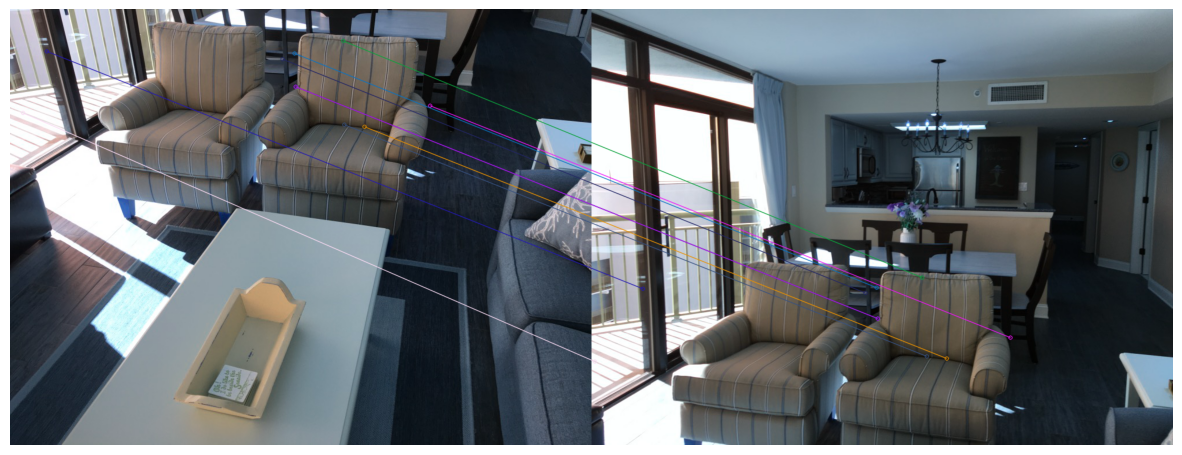

In [6]:
# Primer sa dijagramom za prve dve slike iz skupa
sift = cv.SIFT_create()

img1 = input_images[13]
img2 = input_images[14]
 
# pronalazenje kljucnih tacaka i deskriptora pomocu SIFT algoritma
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
 
# FLANN parametri za KD stabla. trees = 5 je broj stabala koja se koriste za pretragu - sto ih je vise, to je sporije, ali i preciznije
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# koliko puta treba obici stablo - sto je veci broj, to je sporije, ali i tacnije
search_params = dict(checks = 100)
 
flann = cv.FlannBasedMatcher(index_params, search_params)

# Izracunavanje najboljih parova deskriptora izmedju dve slike
matches = flann.match(des1, des2)
 
# Sortiranje parova po rastojanju
matches = sorted(matches, key = lambda x:x.distance)
print(evaluate_matches(matches), "is the average distance of the matches")

# Plotovanje prvih 10 parova
matches_to_draw = matches[:10]
plotImageFLANN = cv.drawMatches(img1, kp1, img2, kp2, matches_to_draw, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(plotImageFLANN)
plt.show()


126.83 is the average distance of the KNN matches


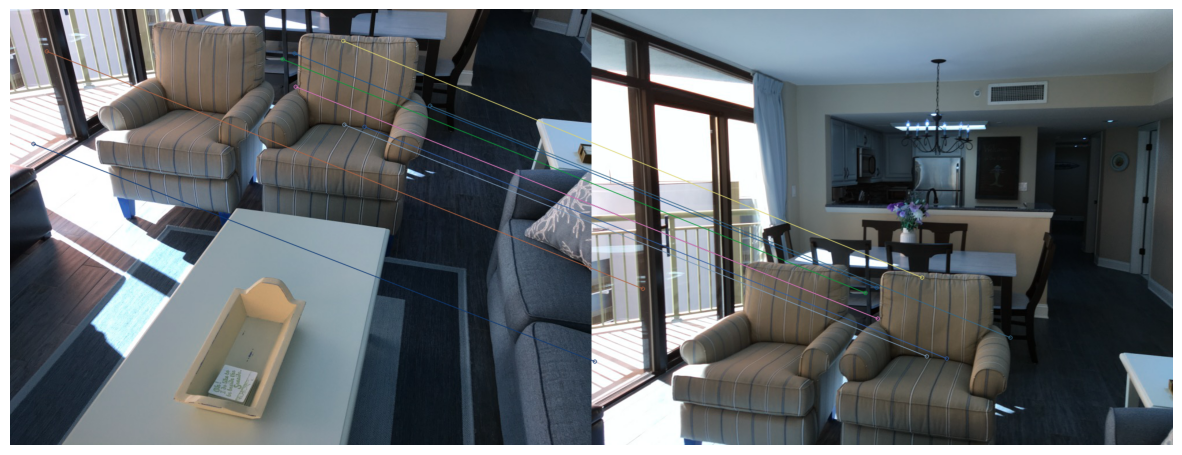

In [7]:
# unapredjenje sa trazenjem k najboljih upraivanja. k = 2 kako bismo mogli da primenimo spomenuti Lowe's ratio test

matchesK = flann.knnMatch(des1, des2, k=2)
good_matches = []

# Lowe's ratio test
for i, (x, y) in enumerate(matchesK):
    if x.distance < 0.75 * y.distance:
        good_matches.append(x)
 
good_matches = sorted(good_matches, key=lambda x: x.distance)
 
matches_to_drawK = good_matches[:10]
plotImageFLANNK = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

print(evaluate_matches(good_matches), "is the average distance of the KNN matches")
 
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(plotImageFLANNK)
plt.show()

## Racunanje homografije

Homografija je matrica transformacija koja prevodi jednu ravan u drugu ravan kroz tacku projekcije (tacka kamere).
<br><br><img src="images/homography_composition.png" alt="Feature extraction" width="500"/>

Pretpostavka koju moramo uvesti ovde je da:
1. Tacke scene leze na istoj ravni
2. Tacke su slikane iz iste tacke (tacke kamere)
3. **Tacke su veoma udaljene** (sto je najcesci slucaj kada su u pitanju panorame, jer retko ce slike biti uslikane bez imalo pomeranja kamere)

### Postavka problema

Ako imamo tacku Ps koja predstavlja tacku izvora sa prve slike i Pd koje je tacka destinacije na drugoj slici, tada imamo projektivno preslikavanje:

\begin{bmatrix}x_d \\ y_d \\ 1 \end{bmatrix} = \begin{bmatrix}\tilde{x_d} \\ \tilde{y_d} \\ \tilde{z_d} \end{bmatrix} = \begin{bmatrix}h_{11} && h_{12} && h_{13} \\ h_{21} && h_{22} && h_{23} \\ h_{31} && h_{32} && h_{33} \end{bmatrix} \begin{bmatrix}x_s \\ y_s \\ 1 \end{bmatrix}

Minimum parova tacaka koji nam je potreban za izracunavanje homografije je 4 (jer zbog osobina homogenih koordinata mozemo da eliminisemo jednu pa imamo 8 nepoznathih), ali uvek zelimo da upotrebimo sto vise kako bismo dobili sto precizniju homografiju.

Za par tacaka sa indeksom i:

$$
\displaystyle x_d^{(i)} = \frac{\tilde{x_d}^{(i)}}{\tilde{z_d}^{(i)}} = \frac{h_{11}x_s^{(i)} + h_{12}y_s^{(i)} + h_{13}}{h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33}}
$$

$$
\displaystyle y_d^{(i)} = \frac{\tilde{y_d}^{(i)}}{\tilde{z_d}^{(i)}} = \frac{h_{21}x_s^{(i)} + h_{22}y_s^{(i)} + h_{23}}{h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33}}
$$

Zapisano u malo drugacijem formatu:

$$
\displaystyle x_d^{(i)} (h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33}) = h_{11}x_s^{(i)} + h_{12}y_s^{(i)} + h_{13}
$$

$$
\displaystyle y_d^{(i)} (h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33} )= h_{21}x_s^{(i)} + h_{22}y_s^{(i)} + h_{23}
$$

I zapisano u matricnom obliku:
\begin{bmatrix}x_s^{(i)} && y_s^{(i)} && 1 && 0 && 0 && 0 && -x_d{(i)}x_s{(i)} && -x_d{(i)}y_s{(i)} && -x_d{(i)} \\ 0 && 0 && 0 && x_s^{(i)} && y_s^{(i)} && 1 && -y_d{(i)}x_s{(i)} && -y_d{(i)}y_s{(i)} && -y_d{(i)} \end{bmatrix} \begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32} \\ h_{33}\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}

Ako to ukombinujemo sa svih datih n tacaka:
\begin{bmatrix}x_s^{(1)} && y_s^{(1)} && 1 && 0 && 0 && 0 && -x_d{(1)}x_s{(1)} && -x_d{(1)}y_s{(1)} && -x_d{(1)} \\ 0 && 0 && 0 && x_s^{(1)} && y_s^{(1)} && 1 && -y_d{(1)}x_s{(1)} && -y_d{(1)}y_s{(1)} && -y_d{(1)} \\ \vdots \\ x_s^{(i)} && y_s^{(i)} && 1 && 0 && 0 && 0 && -x_d{(i)}x_s{(i)} && -x_d{(i)}y_s{(i)} && -x_d{(i)} \\ 0 && 0 && 0 && x_s^{(i)} && y_s^{(i)} && 1 && -y_d{(i)}x_s{(i)} && -y_d{(i)}y_s{(i)} && -y_d{(i)} \\ \vdots \\ x_s^{(n)} && y_s^{(n)} && 1 && 0 && 0 && 0 && -x_d{(n)}x_s{(n)} && -x_d{(n)}y_s{(n)} && -x_d{(n)} \\ 0 && 0 && 0 && x_s^{(n)} && y_s^{(n)} && 1 && -y_d{(n)}x_s{(n)} && -y_d{(n)}y_s{(n)} && -y_d{(n)}\end{bmatrix} \begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32} \\ h_{33}\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ 0 \\ \vdots \\ 0 \\ 0\end{bmatrix}

Pa sustinski treba resiti $A h = 0$, sa dodatim uslovom da je $||h||^2 = 1$



### Izracunavanje $A h = 0$, kada je $||h||^2 = 1$

Resava se metodom najmanjih kvadrata sa organicenjem.
Definicija problema:

$$
\displaystyle \min\limits_{h} ||Ah||^2 \text{ tako da je } \displaystyle ||h||^2 = 1
$$

Ono sto znamo je da:

$$
\displaystyle ||Ah||^2 = (Ah)^T(Ah) = h^TA^TAh \text{ i } ||h||^2 = h^Th = 1
$$

Tako da ono sto trazimo je zapravo:

$$
\displaystyle \min\limits_{h} (h^TA^TAh) \text{ tako da je } \displaystyle h^Th = 1
$$

Za ovo nam je potreban metod Lagranzevih multiplikatora. Osnovna ideja je da se problem sa organicenjem svede na neogranicen problem kako bi se mogli primeniti testovi pomocu izvoda da bi se nasao minimum. Veza izmedju gradijenta funkcije i organicenja u opstem obliku izgleda ovako:

$$
\displaystyle {\mathcal {L}}(x,\lambda )\equiv f(x)+\langle \lambda ,g(x)\rangle
$$

i vrednost **$\lambda$** se zove upravo Lagranzev multiplikator.

U nasem slucaju, funkcija greske izgleda ovako:

$$
\displaystyle {\mathcal {L}}(h,\lambda )\equiv h^TA^TAh + \lambda\langle h^Th - 1 \rangle
$$

Kada izracunamo prvi izvod ove funkcije po h i izjednacimo sa 0 kako bismo dobili stacionarne tacke funkcije:

$$
2A^TAh - 2\lambda h = 0
$$

odnosno

$$
2A^TAh = 2\lambda h
$$

sto je zapravo problem sopstvenih vrednosti i sopstvenih vektora matrice A.

**Konacno, sopstveni vektor h sa najmanjom sopstvenom vrednoscu $\lambda$ matrice $A^TA$ minimizuje funkciju greske $L(h)$.**

Kada se vektor h zapise kao 3x3 matrica dobija se trazena homografija.

### Sta raditi sa anomalijama medju parovima tacaka?

Vrlo cesto ce nam algoritmi za prepoznavanje pored odgovarajucih tacaka dati i neke pogresne rezultate koji nam mogu pokvariti rezultat.
Sa njima se takodje treba pozabaviti i za to se koristi tehnika koja se zove **RANSAC** (Random sample consensus) algoritam.
RANSAC algoritam postoji jos od ranih 80-tih godina proslog veka i ima razne upotrebe. Veoma je mocan - moze se desiti da postoji veliki broj anomalija medju tackama i on ce se odlicno izboriti, sve dok broj anomalija ne prelazi 50% ukupnog broja tacaka.

Koraci u RANSAC algoritmu:
1. Nasumicno odabrati S tacaka
2. Ubaciti nasumicno odabrane tacke u model
3. Definisati prihvatljivu gresku $\epsilon$ i prebrojati koji broj tacaka - M ce primenom modela imati gresku manju od $\epsilon$
4. Ponavljati korake 1-3 N puta
5. Odabrati onaj model koji ima najveci broj M

U primeru homografije:
1. Odaberemo 4 tacke jer znamo da je to potreban minimum za formiranje modela
2. Formiramo matricu homografije sa dobijenim tackama h
3. Gresku $\epsilon$ definisemo kao rastojanje od stvarne tacke i onu koju nam da model. Primenimo matricu h na svaku tacku i izracunamo rastojanje izmedju rezultata i onoga sto smo zapravo dobili kao par za tu tacku. Izbrojimo koliko imamo tacaka koje su ovim kriterijumom oznacene kao ispravne i tako dobijemo M.
4. Ponavljamo korake 1-3 N puta
5. Odaberemo matricu koja je dala najveci broj za M

## Geometrijska transformacija

Medju slikama na ulazu biracemo jednu sliku koja ce nam biti referenca i na sve ostale cemo primeniti izracunatu homografiju kako bismo ostale slike preveli u koordinatni sistem referentne slike.
Medjutim, i tu postoji nekoliko tehnickih problema.

Ako imamo transformaciju T i sliku $f(x, y)$ i hocemo da izracunamo transformisanu sliku $g(x, y)$:

$$
g(x,y)=f(T(x,y))
$$

Sto deluje jednostavno. Medjutim sa tehnicke strane postoje dva problema:
1. Sta se desi ako je rezultujuci piksel izmedju dva piksela? Mozemo uzeti boju najblizeg suseda ili raditi interpolaciju suseda da dobijemo odgovarajucu boju.
2. Sta se desava ako nisu svi pikseli u mapiranju pokriveni? Mogu postojati rupe u $g(x,y)$. Ovaj problem je nezgodniji za resavanje.

Da resimo problem rupa ne radimo direktnu nego suprotnu transformaciju $T^{-1}$.

To radimo tako sto prvo iz prve slike uzmemo coskove i mapiramo ih pomocu T.
Time dobijamo okvir slike $g(x, y)$ i koordinate piksela slike g. Na njih primenjujemo inverznu transformaciju $T^{-1}$.


## Stapanje slika

Kada se nakon svega slike poravnaju ono sto ce se desiti jeste da ce se videti linije, odnosno ivice na mestima gde se slike spajaju koje dolaze od razlika u svetlosti, ekspoziciji i slicno.
Potreban nam je neki nacin da stopimo slike tako da se ova razlika ne vidi.

Resenje ovog problema lezi u racunanju tezinskih funkcija koje govore o tome sa kojom tezinom se uzimaju pikseli iz koje slike.
Ako imamo tri slike $I_1, I_2, I_3$ za svaku treba da izracunamo tezinsku funkciju $\omega_1, \omega_2, \omega_3$.
Funkcija koju cemo koristiti: Tezina koju dodeljujemo svakom pikselu je funkcija rastojanja svakog piksela od najblize ivice slike.
Ideja je da pikseli koji su blize ivicama dobiju manje tezine.

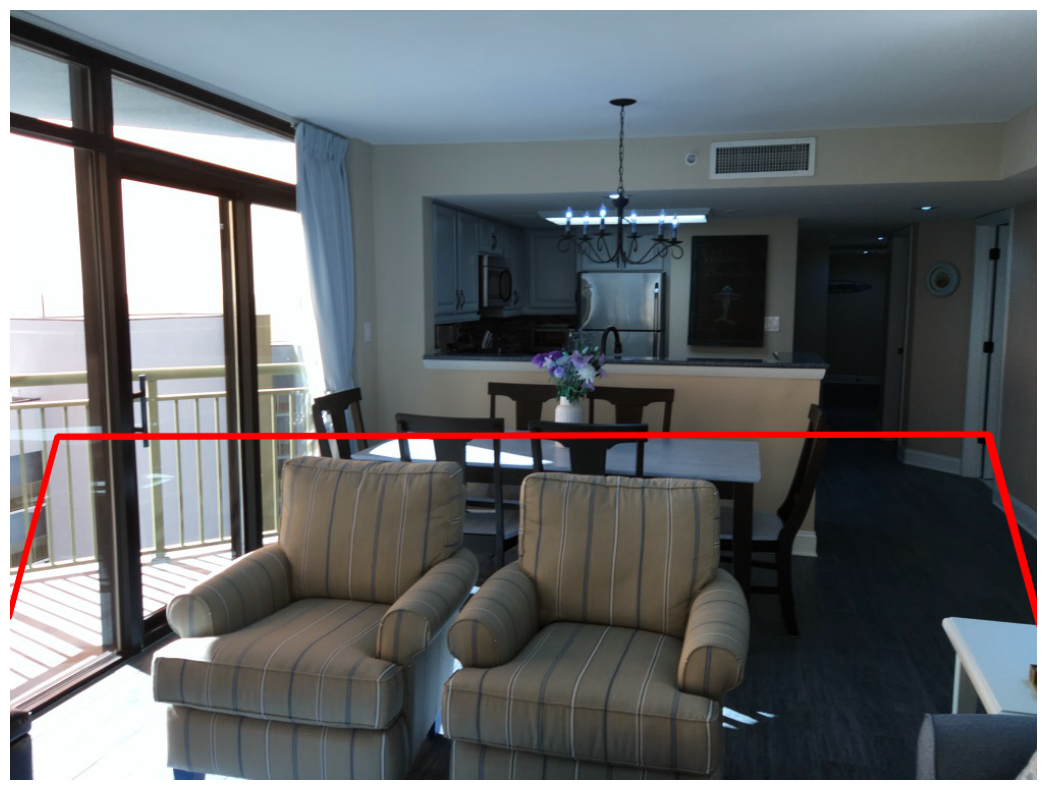

In [10]:
# Implementacija racunanja homografije u openCV biblioteci

MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
 
    M, mask = cv.findHomography(src_pts, dst_pts, cv.LMEDS, 5.0)
    matchesMask = mask.ravel().tolist()
 
    h,w = img1.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
 
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = None

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(img2)
plt.show()

## Primer upotrebe